Market Efficiency Analysis for Prediction Markets
----------------------------------------------
This notebook analyzes the efficiency of prediction markets using various statistical tests to evaluate
whether these markets follow the "wisdom of crowds" hypothesis.
## 1. Introduction & Research Questions

This analysis aims to answer the following research questions:
1. Do prediction markets on Polymarket exhibit weak-form efficiency?
2. How does efficiency vary across different market types and contexts?
3. Does efficiency change over a market's lifecycle?
4. Can one market predict price movements in related markets?

Efficient markets should have the following characteristics:
- Non-stationary price series (random walk)
- Stationary return series
- No significant autocorrelation in returns
- No significant predictability through AR models
- Variance ratios close to 1



## 2. Setup & Data Loading

In [1]:

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import time
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
import json
from scipy import stats

# Try to use the notebook progress bar, fall back to terminal version if not available
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Add the src directory to the path if it isn't already there
if '../src' not in sys.path:
    sys.path.append('../src')

# Import utility functions
from src.utils.data_loader import load_main_dataset, load_trade_data, get_sample_market_ids, load_market_question_mapping

# Create output directory for saving results
results_dir = 'results/knowledge_value/efficiency'
os.makedirs(results_dir, exist_ok=True)


 ## 3. Load and Explore the Dataset

In [2]:
# %%
# Load the main dataset
print("Loading main dataset...")
main_df = load_main_dataset('data/cleaned_election_data.csv')
print(f"Loaded dataset with {main_df.shape[0]} rows and {main_df.shape[1]} columns")

# Create a custom market questions mapping directly from the DataFrame
market_questions = dict(zip(main_df['id'], main_df['question']))
print(f"Created mapping for {len(market_questions)} markets")

# %%
# Check column names to understand available data
print("\nColumn names in the dataset:")
print(main_df.columns.tolist())

# %% [markdown]
# ### Determine ID Column for Markets

# %%
# Determine ID column
id_column = None
if 'market_id' in main_df.columns:
    id_column = 'market_id'
elif 'id' in main_df.columns:
    id_column = 'id'
else:
    # Use the first column as ID
    id_column = main_df.columns[0]
    print(f"Using {id_column} as the ID column")

print(f"Using {id_column} as market identifier column")

# %%
# Display some sample data
print("\nSample data:")
display(main_df.head())

# %%
# Get distribution of market types
if 'event_electionType' in main_df.columns:
    print("\nDistribution of market types:")
    display(main_df['event_electionType'].value_counts())

# %%
# Get distribution by region/country
if 'event_country' in main_df.columns:
    print("\nDistribution by country:")
    display(main_df['event_country'].value_counts().head(10))

Loading main dataset...
Loaded dataset with 1048575 rows and 54 columns
Loaded dataset with 1048575 rows and 54 columns
Created mapping for 1048575 markets

Column names in the dataset:
['id', 'question', 'slug', 'groupItemTitle', 'startDate', 'endDate', 'description', 'outcomes', 'outcomePrices', 'volumeNum', 'volumeClob', 'enableOrderBook', 'active', 'clobTokenIds', 'event_id', 'event_ticker', 'event_slug', 'event_title', 'event_description', 'event_volume', 'event_country', 'event_electionType', 'event_commentCount', 'market_start_date', 'market_end_date', 'correct_outcome', 'yes_token_id', 'closing_price', 'price_2days_prior', 'pre_election_vwap_48h', 'price_volatility', 'price_range', 'final_week_momentum', 'price_fluctuations', 'last_trade_price', 'prediction_correct', 'prediction_error', 'prediction_confidence', 'market_duration_days', 'trading_frequency', 'buy_sell_ratio', 'trading_continuity', 'late_stage_participation', 'volume_acceleration', 'unique_traders_count', 'trader_t

,id,question,slug,groupItemTitle,startDate,endDate,description,outcomes,outcomePrices,volumeNum,...,unique_traders_count,trader_to_trade_ratio,two_way_traders_ratio,trader_concentration,new_trader_influx,comment_per_vol,comment_per_trader,actual_outcome,brier_score,log_loss
0,253591.0,Will Donald Trump win the 2024 US Presidential...,will-donald-trump-win-the-2024-us-presidential...,Donald Trump,2024-01-04T22:58:00Z,2024-11-05T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Donal...,"[""Yes"", ""No""]","[""1"", ""0""]",1.531479e+09,...,62065.0,9.167808,0.409119,1.481972,0.000000,0.000136522,3.368742447,1,0.198025,0.588787
1,253597.0,Will Kamala Harris win the 2024 US Presidentia...,will-kamala-harris-win-the-2024-us-presidentia...,Kamala Harris,2024-01-04T23:02:00Z,2024-11-04T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Kamal...,"[""Yes"", ""No""]","[""0"", ""1""]",1.037039e+09,...,72183.0,11.110649,0.547705,1.436252,0.000000,0.000201613,2.896540737,0,0.159201,0.509160
2,253642.0,Will any other Republican Politician win the 2...,will-any-other-republican-politician-win-the-2...,Other Republican Politician,2024-01-06T20:13:00Z,2024-11-05T00:00:00Z,This market will resolve to ‚ÄúYes‚Äù if any o...,"[""Yes"", ""No""]","[""0"", ""1""]",2.416551e+08,...,22339.0,8.668517,0.851694,1.549498,0.020055,0.000865204,9.359461032,0,0.000001,0.001001
3,253727.0,Kamala Harris wins the popular vote?,will-kamala-harris-win-the-popular-vote-in-the...,Kamala Harris,2024-01-09T23:43:00Z,2024-11-05T12:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Kamal...,"[""Yes"", ""No""]","[""0"", ""1""]",1.637798e+08,...,49608.0,8.552451,0.455048,1.540710,0.285861,3.17E-05,0.104499274,0,0.546121,1.343235
4,253609.0,Will Michelle Obama win the 2024 US Presidenti...,will-michelle-obama-win-the-2024-us-presidenti...,Michelle Obama,2024-01-05T22:01:00Z,2024-11-05T00:00:00Z,This market will resolve to ‚ÄúYes‚Äù if Miche...,"[""Yes"", ""No""]","[""0"", ""1""]",1.533823e+08,...,18963.0,7.649686,0.780414,1.505387,0.013922,0.001363137,11.02573432,0,0.000001,0.001001



Distribution of market types:


event_electionType
 Presidential                  197
 Senate                         49
 Presidential Primary           48
 Parliamentary                  42
 Vice Presidential              41
 Prime Minister                 24
 Presidential Popular Vote      18
 Mayoral                        16
 Presidential Tipping Point     14
 Balance of Power                9
 Presidential Speech             8
 Governor                        7
 Provincial                      7
 Electoral College               6
Presidential Administration      4
Electoral College                3
Presidential                     2
 Senate Primary                  2
Provincial                       2
Prime Minister                   1
Name: count, dtype: int64


Distribution by country:


event_country
United States     368
United Kingdom     21
Germany            15
Ireland            14
Brazil             12
Canada             10
Belarus             7
France              6
Romania             5
Venezuela           5
Name: count, dtype: int64

### 3.1 Select Markets for Analysis

In [10]:
# Get a list of market IDs for analysis
sort_column = 'volumeNum' if 'volumeNum' in main_df.columns else id_column
sample_markets = main_df.sort_values(sort_column, ascending=False)[id_column].unique()

# Limit the number of markets for initial analysis
analysis_markets = sample_markets[:10]  # Adjust based on your computational resources
print(f"\nSelected {len(analysis_markets)} markets for analysis")


Selected 10 markets for analysis


## 4. Methodology & Implementation

### 4.1 Market Data Preprocessing


In [ ]:
def preprocess_market_data(market_id, resample='1min'):
    """
    Convert raw trade data to time series of prices and returns.
    
    Parameters:
    -----------
    market_id : str
        The ID of the market to analyze
    resample : str
        Frequency to resample the time series (default: '1min')
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: timestamp, price, log_return
    """
    # Load trade data for the specific market
    trades_df = load_trade_data(market_id, trades_dir="data/trades")
    
    if trades_df is None or len(trades_df) < 30:
        print(f"Insufficient trade data for market {market_id}")
        return None
    
    # Ensure timestamp is a datetime type
    if not pd.api.types.is_datetime64_any_dtype(trades_df['timestamp']):
        # First convert to numeric to avoid FutureWarning
        if pd.api.types.is_string_dtype(trades_df['timestamp']):
            numeric_timestamps = pd.to_numeric(trades_df['timestamp'], errors='coerce')
            trades_df['timestamp'] = pd.to_datetime(numeric_timestamps, unit='s')
        else:
            trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'], unit='s')
    
    # Sort by timestamp
    trades_df = trades_df.sort_values('timestamp')
    
    # Ensure price is numeric - find the right column
    price_col = None
    for col in ['price', 'price_num']:
        if col in trades_df.columns:
            trades_df[col] = pd.to_numeric(trades_df[col], errors='coerce')
            price_col = col
            break
    
    if price_col is None:
        print(f"No price column found for market {market_id}")
        return None
    
    print(f"Market ID: {market_id}")
    print(f"Original trades count: {len(trades_df)}")
    print(f"Price column: {trades_df['price'].describe()}")
    print(f"Timestamp range: {trades_df['timestamp'].min()} to {trades_df['timestamp'].max()}")
    
    

    # Drop rows with NaN prices
    trades_df = trades_df.dropna(subset=[price_col])
    
    # Use price_col for consistency
    if price_col != 'price':
        trades_df['price'] = trades_df[price_col]
    
    # Resample to regular intervals - this step can be expensive for large datasets
    # Set the index once and avoid unnecessary operations
    trades_df = trades_df.set_index('timestamp')
    
    # Only keep the price column to reduce memory usage
    price_series = trades_df['price']
    
    # Use efficient resampling with forward fill
    price_series = price_series.resample(resample).last().ffill()
    
    # Check for adequate data after resampling
    if len(price_series) < 10:
        print(f"Insufficient data after resampling for market {market_id}")
        return None
    
    # Calculate log returns - avoid duplicate calculations
    log_returns = np.log(price_series / price_series.shift(1))
    
    # Create DataFrame efficiently
    result_df = pd.DataFrame({
        'price': price_series,
        'log_return': log_returns
    })
    
    # Drop NaN values (first row will have NaN log return)
    result_df = result_df.dropna()
    
    return result_df

# Create a cache for market data
market_data_cache = {}

def preprocess_market_data_cached(market_id, resample='1min'):
    """
    Cached version of preprocess_market_data that stores results for reuse
    
    Parameters:
    -----------
    market_id : str
        The ID of the market to analyze
    resample : str
        Frequency to resample the time series (default: '1min')
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: timestamp, price, log_return
    """
    # Normalize market_id to ensure consistent cache keys
    cache_key = (str(market_id), resample)
    
    # Check if already in cache
    if cache_key in market_data_cache:
        return market_data_cache[cache_key]
    
    # If not in cache, process and store
    result = preprocess_market_data(market_id, resample)
    if result is not None:
        market_data_cache[cache_key] = result
    return result

### 4.2 Test a Single Market


Testing preprocessing on market: Market 253591.0 (ID: 253591.0)
Loaded dataset with 1048575 rows and 54 columns
Market ID: 253591.0
Original trades count: 1185000
Price column: count    1.185000e+06
mean     4.746127e-01
std      6.653715e-02
min      2.400000e-01
25%      4.410000e-01
50%      4.930000e-01
75%      5.090000e-01
max      7.500000e-01
Name: price, dtype: float64
Timestamp range: 2024-01-05 02:36:24 to 2024-10-23 15:21:03
Successfully processed market data with 421245 rows


,price,log_return
timestamp,,
2024-01-05 02:37:00,0.42,0.0
2024-01-05 02:38:00,0.42,0.0
2024-01-05 02:39:00,0.42,0.0
2024-01-05 02:40:00,0.42,0.0
2024-01-05 02:41:00,0.42,0.0


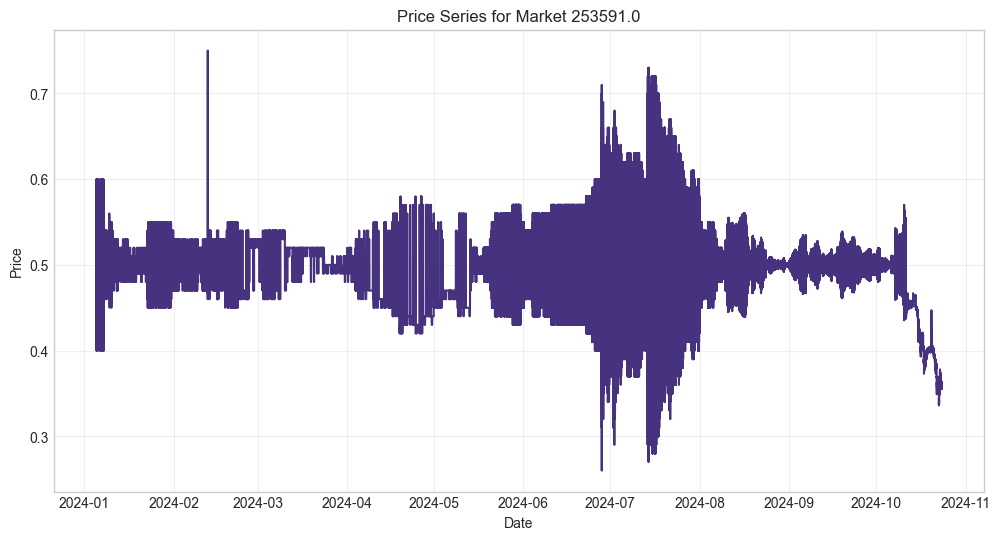

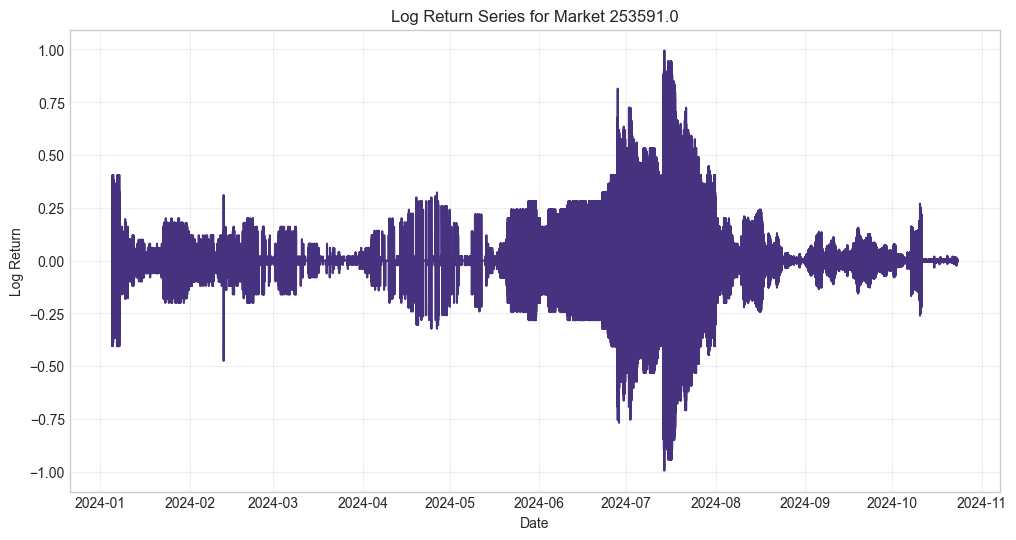

In [17]:
# Test the preprocessing function on one market
test_market_id = analysis_markets[0]
market_name = market_questions.get(str(test_market_id), f"Market {test_market_id}")
print(f"\nTesting preprocessing on market: {market_name} (ID: {test_market_id})")

market_data = preprocess_market_data(test_market_id)

if market_data is not None:
    print(f"Successfully processed market data with {len(market_data)} rows")
    display(market_data.head())
    
    # Plot price series
    plt.figure(figsize=(12, 6))
    plt.plot(market_data.index, market_data['price'])
    plt.title(f'Price Series for Market {test_market_id}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot return series
    plt.figure(figsize=(12, 6))
    plt.plot(market_data.index, market_data['log_return'])
    plt.title(f'Log Return Series for Market {test_market_id}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Failed to process market data. Let's try another market.")
    if len(analysis_markets) > 1:
        test_market_id = analysis_markets[1]
        market_name = market_questions.get(str(test_market_id), f"Market {test_market_id}")
        print(f"Trying market: {market_name} (ID: {test_market_id})")
        market_data = preprocess_market_data(test_market_id)
        if market_data is not None:
            print(f"Successfully processed market data with {len(market_data)} rows")
            display(market_data.head())



### 4.3 Define Efficiency Tests

In [18]:
def run_adf_test(series, series_type='price'):
    """
    Run Augmented Dickey-Fuller test for unit root.
    
    Parameters:
    -----------
    series : pd.Series
        Time series to test
    series_type : str
        Type of series ('price' or 'return')
        
    Returns:
    --------
    dict
        Dictionary with test results
    """
    # Run ADF test
    result = adfuller(series.dropna())
    
    # Format results
    adf_result = {
        'adf_statistic': result[0],
        'pvalue': result[1],
        'critical_values': result[4],
        'is_stationary': result[1] < 0.05  # Reject unit root if p-value < 0.05
    }
    
    return adf_result

def run_autocorrelation_tests(returns, lags=10):
    """
    Run ACF tests on return series.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    lags : int
        Number of lags to test
        
    Returns:
    --------
    dict
        Dictionary with ACF results and significance
    """
    # Calculate ACF
    acf_values = acf(returns, nlags=lags, fft=True)
    
    # Calculate significance threshold
    significance_level = 1.96 / np.sqrt(len(returns))  # 95% confidence level
    
    # Check for significant autocorrelation
    significant_lags = []
    for i in range(1, len(acf_values)):  # Skip lag 0 (always 1)
        if abs(acf_values[i]) > significance_level:
            significant_lags.append(i)
    
    result = {
        'acf_values': acf_values.tolist(),
        'significant_lags': significant_lags,
        'has_significant_autocorrelation': len(significant_lags) > 0
    }
    
    return result

def run_variance_ratio_test(returns, periods=[1, 5, 15, 60]):
    """
    Run variance ratio test to check if variance scales linearly with time.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    periods : list
        List of periods to test
        
    Returns:
    --------
    dict
        Dictionary with variance ratio results
    """
    results = {}
    
    # Calculate variance for base period
    base_period = periods[0]
    base_var = returns.var()
    
    for period in periods[1:]:
        # Skip if we don't have enough data
        if len(returns) < period * 10:
            continue
            
        # Aggregate returns for longer period
        agg_returns = returns.rolling(window=period).sum()
        agg_returns = agg_returns.dropna()
        
        if len(agg_returns) <= 1:
            continue
            
        # Calculate variance
        period_var = agg_returns.var()
        
        # Calculate variance ratio
        var_ratio = period_var / (period * base_var)
        
        # Random walk hypothesis: var_ratio should be close to 1
        # Calculate z-statistic (simplified)
        n = len(returns)
        std_error = np.sqrt(2 * (2 * period - 1) * (period - 1) / (3 * period * n))
        z_stat = (var_ratio - 1) / std_error
        p_value = 2 * (1 - abs(np.exp(-0.5 * z_stat**2) / np.sqrt(2 * np.pi)))
        
        results[f"{period}min"] = {
            'variance_ratio': var_ratio,
            'z_statistic': z_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'interpretation': 'Mean Reversion' if var_ratio < 1 else 'Momentum' if var_ratio > 1 else 'Random Walk'
        }
    
    return results

def run_runs_test(returns):
    """
    Run a runs test to check for non-random patterns in returns.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
        
    Returns:
    --------
    dict
        Dictionary with runs test results
    """
    # Convert returns to binary sequence (1 for positive, 0 for negative)
    binary_seq = (returns > 0).astype(int)
    
    # Count runs
    runs = 1
    for i in range(1, len(binary_seq)):
        if binary_seq.iloc[i] != binary_seq.iloc[i-1]:  # Use iloc for positional indexing
            runs += 1
    
    # Calculate expected runs and variance
    n = len(binary_seq)
    n1 = binary_seq.sum()  # Count of 1s
    n0 = n - n1  # Count of 0s
    
    if n0 == 0 or n1 == 0:  # All returns are positive or negative
        return {
            'runs': runs,
            'expected_runs': np.nan,
            'z_statistic': np.nan,
            'p_value': np.nan,
            'is_random': False
        }
    
    expected_runs = 1 + 2 * n1 * n0 / n
    std_runs = np.sqrt(2 * n1 * n0 * (2 * n1 * n0 - n) / (n**2 * (n-1)))
    
    # Calculate z-statistic
    z_stat = (runs - expected_runs) / std_runs
    p_value = 2 * (1 - abs(np.exp(-0.5 * z_stat**2) / np.sqrt(2 * np.pi)))
    
    return {
        'runs': runs,
        'expected_runs': expected_runs,
        'z_statistic': z_stat,
        'p_value': p_value,
        'is_random': p_value >= 0.05  # Null hypothesis is randomness
    }

def fit_ar_model(returns, lags=1):
    """
    Fit AR model to return series and evaluate predictability.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
    lags : int
        Order of the AR model
        
    Returns:
    --------
    dict
        Dictionary with model results
    """
    if len(returns) <= lags + 2:
        return None
        
    # Fit AR model
    try:
        model = AutoReg(returns, lags=lags)
        model_fit = model.fit()
        
        # Extract coefficient and p-value
        coef = model_fit.params[1] if len(model_fit.params) > 1 else 0
        p_value = model_fit.pvalues[1] if len(model_fit.pvalues) > 1 else 1
        
        return {
            'ar_coefficient': coef,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'aic': model_fit.aic,
            'bic': model_fit.bic
        }
    except Exception as e:
        print(f"Error fitting AR model: {e}")
        return None

def analyze_time_varying_efficiency(returns):
    """
    Analyze how efficiency changes over time by dividing the returns series 
    into early, middle, and late periods.
    
    Parameters:
    -----------
    returns : pd.Series
        Series of log returns
        
    Returns:
    --------
    dict
        Dictionary with time-varying efficiency results
    """
    if len(returns) < 90:  # Need enough data to divide
        return None
    
    # Divide into three periods
    period_size = len(returns) // 3
    early_returns = returns.iloc[:period_size]
    mid_returns = returns.iloc[period_size:2*period_size]
    late_returns = returns.iloc[2*period_size:]
    
    # Test each period
    periods = {
        'early': early_returns,
        'middle': mid_returns,
        'late': late_returns
    }
    
    results = {}
    
    for period_name, period_returns in periods.items():
        if len(period_returns) < 30:  # Skip if not enough data
            continue
        
        # Calculate autocorrelation
        acf_result = run_autocorrelation_tests(period_returns)
        
        # Fit AR model
        ar_result = fit_ar_model(period_returns)
        
        results[period_name] = {
            'significant_acf': acf_result.get('has_significant_autocorrelation', False),
            'ar_model': ar_result,
            'return_volatility': period_returns.std(),
            'sample_size': len(period_returns)
        }
    
    # Compare early vs late
    if 'early' in results and 'late' in results:
        early_ar_sig = results['early'].get('ar_model', {}).get('significant', False) if results['early'].get('ar_model') else False
        late_ar_sig = results['late'].get('ar_model', {}).get('significant', False) if results['late'].get('ar_model') else False
        
        efficiency_change = 'No Change'
        if early_ar_sig and not late_ar_sig:
            efficiency_change = 'More Efficient'
        elif not early_ar_sig and late_ar_sig:
            efficiency_change = 'Less Efficient'
        
        volatility_ratio = results['late']['return_volatility'] / results['early']['return_volatility'] if results['early']['return_volatility'] > 0 else 1
        
        results['comparison'] = {
            'efficiency_change': efficiency_change,
            'volatility_ratio': volatility_ratio,
            'early_more_inefficient': early_ar_sig and not late_ar_sig,
            'late_more_inefficient': not early_ar_sig and late_ar_sig
        }
    
    return results

def analyze_cross_market_predictability(market_ids, max_lag=3):
    """Test for Granger causality between related markets"""
    if len(market_ids) < 2:
        return None
    
    # Process each market
    market_data = {}
    for market_id in market_ids:
        data = preprocess_market_data(market_id, resample='5min')  # Use wider intervals for cross-market
        if data is not None and len(data) > max_lag + 5:
            market_name = market_questions.get(str(market_id), f"Market {market_id}")
            market_data[market_id] = {
                'data': data,
                'name': market_name
            }
    
    if len(market_data) < 2:
        return None
    
    # Pairwise Granger causality tests
    causality_results = []
    
    for i, (market_i, data_i) in enumerate(market_data.items()):
        for j, (market_j, data_j) in enumerate(market_data.items()):
            if i >= j:  # Skip self-comparisons and duplicates
                continue
            
            # Align time series
            common_index = data_i['data'].index.intersection(data_j['data'].index)
            if len(common_index) <= max_lag + 5:
                continue
                
            series_i = data_i['data'].loc[common_index, 'price']
            series_j = data_j['data'].loc[common_index, 'price']
            
            # Test if market i Granger-causes market j
            try:
                # i -> j
                gc_result_ij = grangercausalitytests(
                    pd.concat([series_j, series_i], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ij = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ij.items()])
                
                # j -> i
                gc_result_ji = grangercausalitytests(
                    pd.concat([series_i, series_j], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ji = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ji.items()])
                
                causality_results.append({
                    'market_i_id': market_i,
                    'market_j_id': market_j,
                    'market_i_name': data_i['name'],
                    'market_j_name': data_j['name'],
                    'i_causes_j_pvalue': min_pvalue_ij,
                    'j_causes_i_pvalue': min_pvalue_ji,
                    'i_causes_j': min_pvalue_ij < 0.05,
                    'j_causes_i': min_pvalue_ji < 0.05,
                    'bidirectional': min_pvalue_ij < 0.05 and min_pvalue_ji < 0.05
                })
            except Exception as e:
                print(f"Error in Granger causality test: {e}")
    
    return causality_results

### 4.4 Run Tests on Single Market


Running efficiency tests on market: Market 253591.0

ADF test on price series:
ADF Statistic: -28.7519
p-value: 0.0000
Is stationary: True
Interpretation: Inefficient (not a random walk)

ADF test on return series:
ADF Statistic: -97.5079
p-value: 0.0000
Is stationary: True
Interpretation: Efficient

Autocorrelation test:
Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Has significant autocorrelation: True
Interpretation: Inefficient

Variance ratio test:
  5min: Ratio = 0.4762, p-value = 2.0000, Interpretation: Mean Reversion
  15min: Ratio = 0.2175, p-value = 2.0000, Interpretation: Mean Reversion
  60min: Ratio = 0.0660, p-value = 2.0000, Interpretation: Mean Reversion

Runs test:
Runs: 69543, Expected: 74905.94
Z-statistic: nan, p-value: nan
Is random: False
Interpretation: Inefficient

AR(1) model:
Coefficient: -0.2416
p-value: 0.0000
Significant: True
Interpretation: Inefficient

Time-varying efficiency:
  Early: Significant autocorrelation = True
    AR coefficient = -0.0510,

<Figure size 1000x600 with 0 Axes>

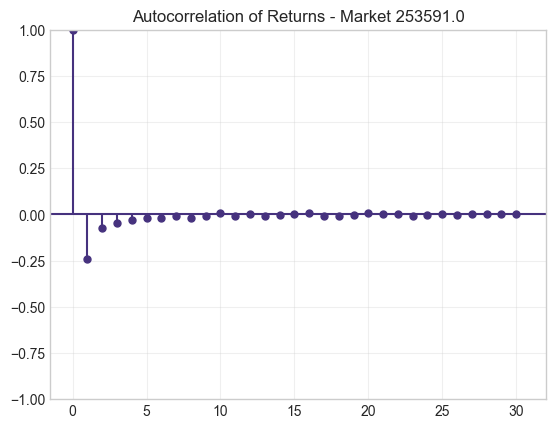

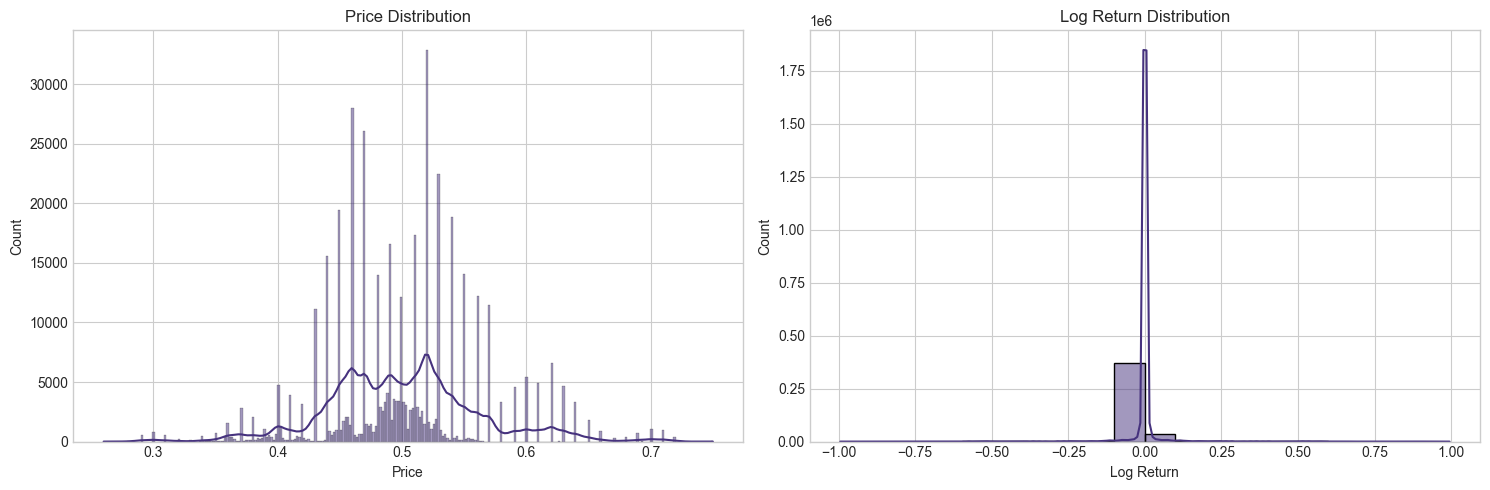

In [19]:
# Run efficiency tests on the test market
if market_data is not None and len(market_data) > 60:
    print("\nRunning efficiency tests on market:", market_name)
    
    # ADF test on price
    adf_price = run_adf_test(market_data['price'], 'price')
    print("\nADF test on price series:")
    print(f"ADF Statistic: {adf_price['adf_statistic']:.4f}")
    print(f"p-value: {adf_price['pvalue']:.4f}")
    print(f"Is stationary: {adf_price['is_stationary']}")
    print(f"Interpretation: {'Inefficient (not a random walk)' if adf_price['is_stationary'] else 'Efficient (random walk)'}")
    
    # ADF test on returns
    adf_return = run_adf_test(market_data['log_return'], 'return')
    print("\nADF test on return series:")
    print(f"ADF Statistic: {adf_return['adf_statistic']:.4f}")
    print(f"p-value: {adf_return['pvalue']:.4f}")
    print(f"Is stationary: {adf_return['is_stationary']}")
    print(f"Interpretation: {'Efficient' if adf_return['is_stationary'] else 'Inefficient'}")
    
    # Autocorrelation test
    acf_result = run_autocorrelation_tests(market_data['log_return'])
    print("\nAutocorrelation test:")
    print(f"Significant lags: {acf_result['significant_lags']}")
    print(f"Has significant autocorrelation: {acf_result['has_significant_autocorrelation']}")
    print(f"Interpretation: {'Inefficient' if acf_result['has_significant_autocorrelation'] else 'Efficient'}")
    
    # Variance ratio test
    vr_result = run_variance_ratio_test(market_data['log_return'])
    print("\nVariance ratio test:")
    for period, result in vr_result.items():
        print(f"  {period}: Ratio = {result['variance_ratio']:.4f}, p-value = {result['p_value']:.4f}, Interpretation: {result['interpretation']}")
    
    # Runs test
    runs_result = run_runs_test(market_data['log_return'])
    print("\nRuns test:")
    print(f"Runs: {runs_result['runs']:.0f}, Expected: {runs_result['expected_runs']:.2f}")
    print(f"Z-statistic: {runs_result['z_statistic']:.4f}, p-value: {runs_result['p_value']:.4f}")
    print(f"Is random: {runs_result['is_random']}")
    print(f"Interpretation: {'Efficient' if runs_result['is_random'] else 'Inefficient'}")
    
    # AR model
    ar_result = fit_ar_model(market_data['log_return'])
    if ar_result:
        print("\nAR(1) model:")
        print(f"Coefficient: {ar_result['ar_coefficient']:.4f}")
        print(f"p-value: {ar_result['p_value']:.4f}")
        print(f"Significant: {ar_result['significant']}")
        print(f"Interpretation: {'Inefficient' if ar_result['significant'] else 'Efficient'}")
    
    # Time-varying efficiency
    tv_result = analyze_time_varying_efficiency(market_data['log_return'])
    if tv_result:
        print("\nTime-varying efficiency:")
        for period_name, period_data in tv_result.items():
            if period_name != 'comparison':
                print(f"  {period_name.capitalize()}: Significant autocorrelation = {period_data.get('significant_acf', False)}")
                if 'ar_model' in period_data and period_data['ar_model']:
                    print(f"    AR coefficient = {period_data['ar_model']['ar_coefficient']:.4f}, significant = {period_data['ar_model']['significant']}")
        
        if 'comparison' in tv_result:
            print(f"  Efficiency change: {tv_result['comparison']['efficiency_change']}")
            print(f"  Volatility ratio (late/early): {tv_result['comparison']['volatility_ratio']:.2f}")
    
    # Create plots
    # ACF plot
    plt.figure(figsize=(10, 6))
    plot_acf(market_data['log_return'], lags=30, alpha=0.05)
    plt.title(f'Autocorrelation of Returns - {market_name}')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Price and returns histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(market_data['price'], kde=True, ax=ax1)
    ax1.set_title('Price Distribution')
    ax1.set_xlabel('Price')
    
    sns.histplot(market_data['log_return'], kde=True, ax=ax2)
    ax2.set_title('Log Return Distribution')
    ax2.set_xlabel('Log Return')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to run efficiency tests")

### 4.5 Representative Market Sample

In [ ]:
def analyze_market_efficiency_sample(top_n_markets=5, by_volume=True, verbose=False):
    """
    Analyze a representative sample of markets for efficiency testing
    
    Parameters:
    -----------
    top_n_markets : int
        Number of markets to analyze
    by_volume : bool
        Whether to select markets by volume (True) or randomly (False)
    verbose : bool
        Whether to print detailed information
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with efficiency results for the sample markets
    """
    global main_df, id_column
    
    # Select the sample markets
    if by_volume:
        # Sort by volume if available
        sort_column = 'volumeNum' if 'volumeNum' in main_df.columns else id_column
        sample_markets = main_df.sort_values(sort_column, ascending=False)[id_column].unique()[:top_n_markets]
        sample_type = "highest volume"
    else:
        # Random sample
        sample_markets = main_df[id_column].sample(top_n_markets).values
        sample_type = "random"
    
    print(f"Analyzing {sample_type} sample of {len(sample_markets)} markets...")
    
    # Process each market
    results = []
    for market_id in sample_markets:
        try:
            market_result = {'market_id': market_id}
            
            # Get market name
            market_name = None
            try:
                market_rows = main_df[main_df[id_column] == market_id]
                if len(market_rows) > 0 and 'question' in market_rows.columns:
                    market_name = market_rows.iloc[0]['question']
            except:
                pass
            
            if market_name is None:
                try:
                    # Try to get from market_questions mapping
                    market_name = market_questions.get(str(market_id), f"Market {market_id}")
                except:
                    market_name = f"Market {market_id}"
            
            market_result['market_name'] = market_name
            
            if verbose:
                print(f"\nAnalyzing market: {market_name} (ID: {market_id})")
            
            # Preprocess market data
            market_data = preprocess_market_data_cached(market_id, verbose=verbose)
            if market_data is None:
                if verbose:
                    print(f"Skipping market {market_id}: insufficient data")
                continue
            
            # Get market metadata
            market_rows = main_df[main_df[id_column] == market_id]
            if len(market_rows) == 0:
                # Try string comparison
                market_rows = main_df[main_df[id_column].astype(str) == str(market_id)]
            
            if len(market_rows) > 0:
                row = market_rows.iloc[0]
                
                # Extract market information safely
                for col, result_key in [
                    ('event_electionType', 'event_type'),
                    ('event_country', 'country'),
                    ('volumeNum', 'volume'),
                    ('market_duration_days', 'duration_days')
                ]:
                    if col in row and not pd.isna(row[col]):
                        market_result[result_key] = row[col]
            
            # Run efficiency tests
            # 1. ADF tests
            market_result['adf_price'] = run_adf_test(market_data['price'], 'price')
            market_result['adf_return'] = run_adf_test(market_data['log_return'], 'return')
            
            # 2. Autocorrelation tests
            market_result['autocorrelation'] = run_autocorrelation_tests(market_data['log_return'])
            
            # 3. Variance ratio test
            market_result['variance_ratio'] = run_variance_ratio_test(market_data['log_return'])
            
            # 4. Runs test
            market_result['runs_test'] = run_runs_test(market_data['log_return'])
            
            # 5. AR model
            market_result['ar_model'] = fit_ar_model(market_data['log_return'])
            
            # 6. Time-varying efficiency analysis
            market_result['time_varying'] = analyze_time_varying_efficiency(market_data['log_return'])
            
            # Calculate efficiency score
            efficiency_score = calculate_efficiency_score(market_result)
            market_result['efficiency_score'] = efficiency_score
            
            # Classification
            if efficiency_score >= 80:
                market_result['efficiency_class'] = 'Highly Efficient'
            elif efficiency_score >= 60:
                market_result['efficiency_class'] = 'Moderately Efficient'
            elif efficiency_score >= 40:
                market_result['efficiency_class'] = 'Slightly Inefficient'
            else:
                market_result['efficiency_class'] = 'Highly Inefficient'
            
            results.append(market_result)
            
            if verbose:
                print(f"Completed analysis for {market_name} - Efficiency Score: {efficiency_score:.2f}/100")
        
        except Exception as e:
            print(f"Error analyzing market {market_id}: {e}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print summary information
    print("\nAnalysis complete!")
    print(f"Successfully analyzed {len(results_df)}/{len(sample_markets)} markets")
    if len(results_df) > 0:
        print(f"Average efficiency score: {results_df['efficiency_score'].mean():.2f}/100")
        print("\nEfficiency Classification:")
        for cls, count in results_df['efficiency_class'].value_counts().items():
            print(f"  {cls}: {count} markets ({count/len(results_df)*100:.1f}%)")
    
    return results_df

def calculate_efficiency_score(market_result):
    """Calculate an efficiency score based on various test results"""
    score = 0
    max_points = 0
    
    # 1. Non-stationary price (random walk) = efficient
    if 'adf_price' in market_result:
        max_points += 1
        if not market_result['adf_price']['is_stationary']:
            score += 1
    
    # 2. Stationary returns = efficient
    if 'adf_return' in market_result:
        max_points += 1
        if market_result['adf_return']['is_stationary']:
            score += 1
    
    # 3. No significant autocorrelation = efficient
    if 'autocorrelation' in market_result:
        max_points += 1
        if not market_result['autocorrelation']['has_significant_autocorrelation']:
            score += 1
    
    # 4. Random runs test = efficient
    if 'runs_test' in market_result:
        max_points += 1
        if market_result['runs_test']['is_random']:
            score += 1
    
    # 5. No significant AR model = efficient
    if 'ar_model' in market_result and market_result['ar_model']:
        max_points += 1
        if not market_result['ar_model']['significant']:
            score += 1
    
    # 6. Variance ratio close to 1 = efficient
    if 'variance_ratio' in market_result and market_result['variance_ratio']:
        vr_count = 0
        vr_score = 0
        for period, result in market_result['variance_ratio'].items():
            max_points += 0.5
            vr_count += 0.5
            if not result['significant']:  # Not significantly different from 1
                score += 0.5
                vr_score += 0.5
    
    # Calculate percentage
    if max_points > 0:
        efficiency_score = (score / max_points) * 100
    else:
        efficiency_score = 0
    
    return efficiency_score

In [ ]:
def visualize_market_efficiency_results(results_df, save_dir=None):
    """
    Create visualizations of market efficiency results
    
    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame with efficiency results
    save_dir : str, optional
        Directory to save plots
    """
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # 1. Efficiency score distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['efficiency_score'], bins=20, kde=True)
    plt.axvline(x=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
               label=f'Mean: {results_df["efficiency_score"].mean():.2f}')
    plt.title('Distribution of Market Efficiency Scores', fontsize=14)
    plt.xlabel('Efficiency Score (higher = more efficient)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'efficiency_score_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Efficiency classification pie chart
    plt.figure(figsize=(10, 8))
    results_df['efficiency_class'].value_counts().plot.pie(autopct='%1.1f%%', 
                                                         colors=sns.color_palette("viridis", 4),
                                                         startangle=90, 
                                                         textprops={'fontsize': 12})
    plt.title('Market Efficiency Classification', fontsize=14)
    plt.ylabel('')  # Hide ylabel
    
    if save_dir:
        plt.savefig(os.path.join(save_dir, 'efficiency_classification_pie.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Test results summary
    test_results = []
    
    if 'adf_price' in results_df.columns:
        price_stationary = results_df['adf_price'].apply(lambda x: x['is_stationary'] if isinstance(x, dict) else False).mean() * 100
        test_results.append(('Non-Stationary Prices', 100 - price_stationary))
    
    if 'adf_return' in results_df.columns:
        return_stationary = results_df['adf_return'].apply(lambda x: x['is_stationary'] if isinstance(x, dict) else False).mean() * 100
        test_results.append(('Stationary Returns', return_stationary))
    
    if 'autocorrelation' in results_df.columns:
        no_autocorr = 100 - results_df['autocorrelation'].apply(
            lambda x: x['has_significant_autocorrelation'] if isinstance(x, dict) else False).mean() * 100
        test_results.append(('No Significant Autocorrelation', no_autocorr))
    
    if 'runs_test' in results_df.columns:
        random_runs = results_df['runs_test'].apply(lambda x: x['is_random'] if isinstance(x, dict) else False).mean() * 100
        test_results.append(('Random Runs Test', random_runs))
    
    if 'ar_model' in results_df.columns:
        no_sig_ar = 100 - results_df['ar_model'].apply(
            lambda x: x.get('significant', False) if isinstance(x, dict) else False).mean() * 100
        test_results.append(('No Significant AR Model', no_sig_ar))
    
    # Plot if we have results
    if test_results:
        test_df = pd.DataFrame(test_results, columns=['Test', 'Pass Rate (%)'])
        test_df = test_df.sort_values('Pass Rate (%)', ascending=False)
        
        plt.figure(figsize=(12, 6))
        bars = plt.barh(test_df['Test'], test_df['Pass Rate (%)'], color='skyblue')
        
        # Add value labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f"{bar.get_width():.1f}%", ha='left', va='center', fontsize=11)
        
        plt.title('Efficiency Test Pass Rates', fontsize=14)
        plt.xlabel('Pass Rate (%)', fontsize=12)
        plt.xlim(0, 110)
        plt.grid(axis='x', alpha=0.3)
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'efficiency_test_results.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4. Efficiency by market type if available
    if 'event_type' in results_df.columns:
        type_counts = results_df['event_type'].value_counts()
        types_with_sufficient_data = type_counts[type_counts >= 2].index.tolist()
        
        if types_with_sufficient_data:
            plt.figure(figsize=(12, 6))
            
            # Create a DataFrame with efficiency by type
            type_efficiency = results_df[results_df['event_type'].isin(types_with_sufficient_data)].groupby('event_type')['efficiency_score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
            
            bars = plt.bar(type_efficiency.index, type_efficiency['mean'], color='lightgreen')
            
            # Add count labels
            for i, bar in enumerate(bars):
                plt.text(bar.get_x() + bar.get_width()/2, 
                        bar.get_height() + 1, 
                        f"n={type_efficiency['count'].iloc[i]}", 
                        ha='center', va='bottom', fontsize=10)
            
            plt.axhline(y=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
                       label=f'Overall Average: {results_df["efficiency_score"].mean():.2f}')
            
            plt.title('Average Efficiency Score by Market Type', fontsize=14)
            plt.xlabel('Market Type', fontsize=12)
            plt.ylabel('Average Efficiency Score', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.ylim(0, 100)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            if save_dir:
                plt.savefig(os.path.join(save_dir, 'efficiency_by_market_type.png'), dpi=300, bbox_inches='tight')
            plt.show()
    
    # 5. Time-varying efficiency results if available
    time_varying_data = []
    for _, row in results_df.iterrows():
        tv = row.get('time_varying', {})
        if isinstance(tv, dict) and 'comparison' in tv:
            time_varying_data.append({
                'market_id': row['market_id'],
                'market_name': row.get('market_name', f"Market {row['market_id']}"),
                'efficiency_change': tv['comparison'].get('efficiency_change', 'No Change'),
                'volatility_ratio': tv['comparison'].get('volatility_ratio', 1)
            })
    
    if time_varying_data:
        tv_df = pd.DataFrame(time_varying_data)
        
        plt.figure(figsize=(10, 6))
        tv_counts = tv_df['efficiency_change'].value_counts()
        
        # Use appropriate colors
        colors = {'More Efficient': 'green', 'No Change': 'gray', 'Less Efficient': 'red'}
        bar_colors = [colors.get(category, 'blue') for category in tv_counts.index]
        
        bars = plt.bar(tv_counts.index, tv_counts.values, color=bar_colors)
        
        # Add percentage labels
        total = len(tv_df)
        for i, count in enumerate(tv_counts):
            plt.text(i, count + 0.5, f"{count/total*100:.1f}%", ha='center', fontsize=11)
        
        plt.title('Efficiency Change Over Market Lifecycle', fontsize=14)
        plt.ylabel('Number of Markets', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'time_varying_efficiency.png'), dpi=300, bbox_inches='tight')
        plt.show()

## 5. Comprehensive Efficiency Analysis of All Markets

### 5.1 Analysis Framework

In [ ]:
def analyze_market_efficiency(market_id):
    """
    Run a comprehensive market efficiency analysis on a single market.
    
    Parameters:
    -----------
    market_id : str
        ID of the market to analyze
        
    Returns:
    --------
    dict
        Dictionary with efficiency results
    """
    market_result = {'market_id': market_id}
    market_name = market_questions.get(str(market_id), f"Market {market_id}")
    market_result['market_name'] = market_name
    
    # Preprocess market data using cached version
    market_data = preprocess_market_data_cached(market_id)
    if market_data is None or len(market_data) < 30:
        return None
    
    # Get market metadata
    market_rows = main_df[main_df[id_column] == market_id]
    if len(market_rows) == 0:
        # Try string comparison
        market_rows = main_df[main_df[id_column].astype(str) == str(market_id)]
    
    if len(market_rows) > 0:
        row = market_rows.iloc[0]
        
        # Extract market information safely
        if 'event_electionType' in row:
            market_result['event_type'] = row['event_electionType']
        if 'event_country' in row:
            market_result['country'] = row['event_country']
        if 'volumeNum' in row:
            market_result['volume'] = row['volumeNum']
        if 'market_duration_days' in row:
            market_result['duration_days'] = row['market_duration_days']
    
    # Run ADF tests
    market_result['adf_price'] = run_adf_test(market_data['price'], 'price')
    market_result['adf_return'] = run_adf_test(market_data['log_return'], 'return')
    
    # Run autocorrelation tests
    market_result['autocorrelation'] = run_autocorrelation_tests(market_data['log_return'])
    
    # Run variance ratio test
    market_result['variance_ratio'] = run_variance_ratio_test(market_data['log_return'])
    
    # Run runs test
    market_result['runs_test'] = run_runs_test(market_data['log_return'])
    
    # Fit AR model
    market_result['ar_model'] = fit_ar_model(market_data['log_return'])
    
    # Run time-varying efficiency analysis
    market_result['time_varying'] = analyze_time_varying_efficiency(market_data['log_return'])
    
    # Calculate overall efficiency score (0-100, higher = more efficient)
    score = 0
    max_points = 0
    
    # 1. Non-stationary price (random walk) = efficient
    if 'adf_price' in market_result:
        max_points += 1
        if not market_result['adf_price']['is_stationary']:
            score += 1
    
    # 2. Stationary returns = efficient
    if 'adf_return' in market_result:
        max_points += 1
        if market_result['adf_return']['is_stationary']:
            score += 1
    
    # 3. No significant autocorrelation = efficient
    if 'autocorrelation' in market_result:
        max_points += 1
        if not market_result['autocorrelation']['has_significant_autocorrelation']:
            score += 1
    
    # 4. Random runs test = efficient
    if 'runs_test' in market_result:
        max_points += 1
        if market_result['runs_test']['is_random']:
            score += 1
    
    # 5. No significant AR model = efficient
    if 'ar_model' in market_result and market_result['ar_model']:
        max_points += 1
        if not market_result['ar_model']['significant']:
            score += 1
    
    # 6. Variance ratio close to 1 = efficient
    if 'variance_ratio' in market_result and market_result['variance_ratio']:
        vr_count = 0
        for period, result in market_result['variance_ratio'].items():
            max_points += 0.5
            vr_count += 0.5
            if not result['significant']:  # Not significantly different from 1
                score += 0.5
    
    # Calculate percentage
    if max_points > 0:
        efficiency_score = (score / max_points) * 100
    else:
        efficiency_score = 0
    
    market_result['efficiency_score'] = efficiency_score
    
    # Efficiency classification
    if efficiency_score >= 80:
        market_result['efficiency_class'] = 'Highly Efficient'
    elif efficiency_score >= 60:
        market_result['efficiency_class'] = 'Moderately Efficient'
    elif efficiency_score >= 40:
        market_result['efficiency_class'] = 'Slightly Inefficient'
    else:
        market_result['efficiency_class'] = 'Highly Inefficient'
    
    market_result['market_question'] = market_questions.get(str(market_id), 'Unknown')
    market_result['election_type'] = market_info.get('event_electionType', 'Unknown')
    market_result['country'] = market_info.get('event_country', 'Unknown')
    market_result['total_volume'] = market_info.get('volumeNum', 0)
    market_result['market_duration_days'] = market_info.get('market_duration_days', 0)

    return market_result


### 5.2 Run Analysis on All Selected Markets

In [ ]:
def analyze_markets_efficiently(market_ids, max_markets=100, max_workers=None):
    """
    Run market efficiency analysis with improved performance and memory management
    
    Parameters:
    -----------
    market_ids : list
        List of market IDs to analyze
    max_markets : int
        Maximum number of markets to analyze
    max_workers : int, optional
        Number of parallel workers (defaults to CPU cores - 2)
    
    Returns:
    --------
    list
        Processed market efficiency results
    """
    from concurrent.futures import ProcessPoolExecutor, as_completed
    import multiprocessing
    
    # Limit markets to reduce computational load
    market_ids = market_ids[:max_markets]
    
    # Determine optimal number of workers
    if max_workers is None:
        max_workers = max(1, multiprocessing.cpu_count() - 2)
    
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit jobs and collect results as they complete
        futures = {executor.submit(analyze_market_efficiency, market_id): market_id 
                   for market_id in market_ids}
        
        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                results.append(result)
                
                # Optional: print progress
                print(f"Processed market {futures[future]} successfully")
    
    return results

### 5.3 Results Summary

In [ ]:
# Display summary of results
print("\nEfficiency Analysis Summary:")
print(f"Total markets analyzed: {len(efficiency_results)}")

# Create DataFrame if it doesn't exist yet
if 'results_df' not in locals() or not isinstance(results_df, pd.DataFrame):
    results_df = pd.DataFrame(efficiency_results)

if len(results_df) > 0:
    # Overall statistics
    print(f"\nAverage efficiency score: {results_df['efficiency_score'].mean():.2f}/100")
    
    # Efficiency classification counts
    print("\nEfficiency Classification Breakdown:")
    class_counts = results_df['efficiency_class'].value_counts()
    for cls, count in class_counts.items():
        print(f"  {cls}: {count} markets ({count/len(results_df)*100:.1f}%)")
    
    # Test results breakdown
    if 'adf_price' in results_df.columns:
        price_stationary = sum(results_df['adf_price'].apply(lambda x: x['is_stationary']))
        print(f"\nADF Test (Price): {price_stationary} markets ({price_stationary/len(results_df)*100:.1f}%) have stationary prices")
    
    if 'adf_return' in results_df.columns:
        return_stationary = sum(results_df['adf_return'].apply(lambda x: x['is_stationary']))
        print(f"ADF Test (Returns): {return_stationary} markets ({return_stationary/len(results_df)*100:.1f}%) have stationary returns")
    
    if 'autocorrelation' in results_df.columns:
        autocorrelation = sum(results_df['autocorrelation'].apply(lambda x: x['has_significant_autocorrelation']))
        print(f"Autocorrelation: {autocorrelation} markets ({autocorrelation/len(results_df)*100:.1f}%) have significant autocorrelation")
    
    if 'runs_test' in results_df.columns:
        random_runs = sum(results_df['runs_test'].apply(lambda x: x['is_random']))
        print(f"Runs Test: {random_runs} markets ({random_runs/len(results_df)*100:.1f}%) have random runs")
    
    if 'ar_model' in results_df.columns:
        ar_significant = sum(results_df['ar_model'].apply(lambda x: x.get('significant', False) if x else False))
        print(f"AR Model: {ar_significant} markets ({ar_significant/len(results_df)*100:.1f}%) have significant AR(1) coefficients")
else:
    print("No results to summarize. Make sure the analysis completed successfully.")

## 6. Data Visualization and Interpretation
### 6.1 Distribution of Efficiency Score

In [ ]:
# Histogram of efficiency scores
plt.figure(figsize=(10, 6))
sns.histplot(results_df['efficiency_score'], bins=20, kde=True)
plt.axvline(x=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df["efficiency_score"].mean():.2f}')
plt.title('Distribution of Market Efficiency Scores')
plt.xlabel('Efficiency Score (higher = more efficient)')
plt.ylabel('Count')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# %%
# Efficiency classification pie chart
plt.figure(figsize=(10, 8))
results_df['efficiency_class'].value_counts().plot.pie(autopct='%1.1f%%', 
                                                     colors=sns.color_palette("viridis", 4),
                                                     startangle=90)
plt.title('Market Efficiency Classification')
plt.ylabel('')  # Hide ylabel
plt.show()

### 6.2 Efficiency by Market Characteristics


In [ ]:
if 'event_type' in results_df.columns:
    # Filter to include only market types with sufficient data
    type_counts = results_df['event_type'].value_counts()
    market_types = type_counts[type_counts >= 5].index.tolist()
    
    if market_types:
        type_data = []
        for market_type in market_types:
            type_df = results_df[results_df['event_type'] == market_type]
            type_data.append({
                'Market Type': market_type,
                'Average Efficiency': type_df['efficiency_score'].mean(),
                'Count': len(type_df)
            })
        
        type_df = pd.DataFrame(type_data).sort_values('Average Efficiency', ascending=False)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(type_df['Market Type'], type_df['Average Efficiency'], color='skyblue')
        
        # Add count labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                    f"n={type_df['Count'].iloc[i]}", 
                    ha='center', va='bottom')
        
        plt.axhline(y=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
                   label=f'Overall Average: {results_df["efficiency_score"].mean():.2f}')
        
        plt.title('Average Efficiency Score by Market Type')
        plt.xlabel('Market Type')
        plt.ylabel('Average Efficiency Score')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

# %%
# Efficiency by region/country
if 'country' in results_df.columns:
    # Filter to include only countries with sufficient data
    country_counts = results_df['country'].value_counts()
    countries = country_counts[country_counts >= 5].index.tolist()
    
    if countries:
        country_data = []
        for country in countries:
            country_df = results_df[results_df['country'] == country]
            country_data.append({
                'Country': country,
                'Average Efficiency': country_df['efficiency_score'].mean(),
                'Count': len(country_df)
            })
        
        country_df = pd.DataFrame(country_data).sort_values('Average Efficiency', ascending=False)
        
        plt.figure(figsize=(12, 6))
        bars = plt.bar(country_df['Country'], country_df['Average Efficiency'], color='lightgreen')
        
        # Add count labels
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                    f"n={country_df['Count'].iloc[i]}", 
                    ha='center', va='bottom')
        
        plt.axhline(y=results_df['efficiency_score'].mean(), color='red', linestyle='--', 
                   label=f'Overall Average: {results_df["efficiency_score"].mean():.2f}')
        
        plt.title('Average Efficiency Score by Country')
        plt.xlabel('Country')
        plt.ylabel('Average Efficiency Score')
        plt.legend()
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

### 6.3 Efficiency vs Market Characteristics

In [ ]:
# Efficiency vs Market Volume
if 'volume' in results_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['volume'], results_df['efficiency_score'], alpha=0.6)
    plt.xscale('log')  # Use log scale for volume
    plt.title('Efficiency Score vs Market Volume')
    plt.xlabel('Trading Volume (log scale)')
    plt.ylabel('Efficiency Score')
    
    # Add trend line
    try:
        z = np.polyfit(np.log10(results_df['volume']), results_df['efficiency_score'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(results_df['volume']), 
                p(np.log10(sorted(results_df['volume']))), 
                "r--", linewidth=2)
        
        # Calculate correlation
        corr = np.corrcoef(np.log10(results_df['volume']), results_df['efficiency_score'])[0, 1]
        plt.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=plt.gca().transAxes)
    except:
        pass
    
    plt.grid(alpha=0.3)
    plt.show()

# %%
# Efficiency vs Market Duration
if 'duration_days' in results_df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['duration_days'], results_df['efficiency_score'], alpha=0.6)
    plt.title('Efficiency Score vs Market Duration')
    plt.xlabel('Market Duration (days)')
    plt.ylabel('Efficiency Score')
    
    # Add trend line
    try:
        z = np.polyfit(results_df['duration_days'], results_df['efficiency_score'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(results_df['duration_days']), 
                p(sorted(results_df['duration_days'])), 
                "r--", linewidth=2)
        
        # Calculate correlation
        corr = np.corrcoef(results_df['duration_days'], results_df['efficiency_score'])[0, 1]
        plt.text(0.05, 0.95, f"Correlation: {corr:.3f}", transform=plt.gca().transAxes)
    except:
        pass
    
    plt.grid(alpha=0.3)
    plt.show()

### 6.4 Time-Varying Efficiency Analysis


In [ ]:
# Analyze time-varying efficiency results
tv_data = []

for result in efficiency_results:
    tv = result.get('time_varying', {})
    if tv and 'comparison' in tv:
        tv_data.append({
            'market_id': result['market_id'],
            'market_name': result.get('market_name', f"Market {result['market_id']}"),
            'efficiency_change': tv['comparison']['efficiency_change'],
            'early_more_inefficient': tv['comparison'].get('early_more_inefficient', False),
            'late_more_inefficient': tv['comparison'].get('late_more_inefficient', False),
            'volatility_ratio': tv['comparison'].get('volatility_ratio', 1)
        })

if tv_data:
    tv_df = pd.DataFrame(tv_data)
    
    # Count markets in each category
    efficiency_change_counts = tv_df['efficiency_change'].value_counts()
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = efficiency_change_counts.plot.bar(color=['green', 'gray', 'red'])
    
    plt.title('Efficiency Change Over Market Lifecycle')
    plt.xlabel('Efficiency Change')
    plt.ylabel('Number of Markets')
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(tv_df)
    for i, count in enumerate(efficiency_change_counts):
        plt.text(i, count + 0.5, f"{count/total*100:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()

## 7. Cross-Market Analysis (Market Relatedness)

In [ ]:
def find_related_markets(event_id):
    """Find markets that are part of the same event"""
    # Determine the event column
    event_col = None
    for col in ['event_id', 'groupId', 'group_id', 'event']:
        if col in main_df.columns:
            event_col = col
            break
    
    if not event_col:
        print("Could not find an event identifier column")
        return []
    
    # Get markets in this event
    event_markets = main_df[main_df[event_col] == event_id]
    if len(event_markets) <= 1:
        return []
    
    return event_markets[id_column].unique().tolist()

def analyze_cross_market_predictability(market_ids, max_lag=3):
    """Test for Granger causality between related markets"""
    if len(market_ids) < 2:
        return None
    
    # Process each market (using cached version)
    market_data = {}
    for market_id in market_ids:
        data = preprocess_market_data_cached(market_id, resample='5min')  # Use wider intervals for cross-market
        if data is not None and len(data) > max_lag + 5:
            market_name = market_questions.get(str(market_id), f"Market {market_id}")
            market_data[market_id] = {
                'data': data,
                'name': market_name
            }
    
    if len(market_data) < 2:
        return None
    
    # Pairwise Granger causality tests
    causality_results = []
    
    for i, (market_i, data_i) in enumerate(market_data.items()):
        for j, (market_j, data_j) in enumerate(market_data.items()):
            if i >= j:  # Skip self-comparisons and duplicates
                continue
            
            # Align time series
            common_index = data_i['data'].index.intersection(data_j['data'].index)
            if len(common_index) <= max_lag + 5:
                continue
                
            series_i = data_i['data'].loc[common_index, 'price']
            series_j = data_j['data'].loc[common_index, 'price']
            
            # Test if market i Granger-causes market j
            try:
                # i -> j
                gc_result_ij = grangercausalitytests(
                    pd.concat([series_j, series_i], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ij = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ij.items()])
                
                # j -> i
                gc_result_ji = grangercausalitytests(
                    pd.concat([series_i, series_j], axis=1), 
                    maxlag=max_lag, 
                    verbose=False
                )
                min_pvalue_ji = min([res[0]['ssr_chi2test'][1] for lag, res in gc_result_ji.items()])
                
                causality_results.append({
                    'market_i_id': market_i,
                    'market_j_id': market_j,
                    'market_i_name': data_i['name'],
                    'market_j_name': data_j['name'],
                    'i_causes_j_pvalue': min_pvalue_ij,
                    'j_causes_i_pvalue': min_pvalue_ji,
                    'i_causes_j': min_pvalue_ij < 0.05,
                    'j_causes_i': min_pvalue_ji < 0.05,
                    'bidirectional': min_pvalue_ij < 0.05 and min_pvalue_ji < 0.05
                })
            except Exception as e:
                print(f"Error in Granger causality test: {e}")
    
    return causality_results# Market Efficiency Analysis for Prediction Markets